# 3D Brain MRI Segmentation with fastai, MONAI, U-Net & ResNet

**Supports:**
- 3D U-Net (MONAI)
- 3D ResNet (MONAI)
- fastai training loop, metrics, and augmentations
- Single and batch inference

**Targets:** cortex (3, 42), M1 (8), DLPFC (5), etc. (see label codes below)

---

## Dataset & Label Codes
- Dataset: IBSR, preprocessed
- Label codes: cortex: 3, 42; M1: 8; DLPFC: 5; (add more as needed)

---

In [2]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.callback.all import *
import monai
from monai.networks.nets import UNet, BasicUNet, resnet
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityd, ToTensord
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import random


## Label Codes & Targets

```python
label_codes = {
    'background': 0,
    'cortex_left': 3,
    'cortex_right': 42,
    'M1': 8,
    'DLPFC': 5,
    # Add more as needed
}
targets = ['cortex_left', 'cortex_right', 'M1', 'DLPFC']
```


In [3]:
label_codes = {
    'background': 0,
    'cortex_left': 3,
    'cortex_right': 42,
    'M1': 8,
    'DLPFC': 5,
}
targets = ['cortex_left', 'cortex_right', 'M1', 'DLPFC']


## Data Loading Utilities
- Load single or batch 3D MRI images and masks
- Use label codes for mask extraction


In [4]:
def load_nifti(path):
    img = nib.load(str(path))
    data = img.get_fdata()
    return data

def extract_target_mask(mask, label_codes, targets):
    out = np.zeros_like(mask, dtype=np.uint8)
    for i, t in enumerate(targets, 1):
        out[np.isin(mask, label_codes[t])] = i
    return out

def load_image_and_mask(img_path, mask_path, label_codes, targets):
    img = load_nifti(img_path)
    mask = load_nifti(mask_path)
    mask = extract_target_mask(mask, label_codes, targets)
    return img, mask


## Preprocessing
- Z-score normalization
- (Optional) N4ITK, histogram equalization, etc.


In [5]:
def zscore_normalize(img):
    img = img.astype(np.float32)
    mean = img.mean()
    std = img.std()
    return (img - mean) / (std + 1e-8)


## Dataset Paths


In [11]:
IMG_DIR = Path('../data/preprocessed')
MASK_DIR = Path('../data/classical_segmented')
img_files = sorted(list(IMG_DIR.glob('IBSR_*_zscore.nii.gz')))
mask_files = sorted(list(MASK_DIR.glob('IBSR_*_zscore.nii_otsu.nii.gz')))  # or change to _kmeans, _watershed, etc.
print(f'Found {len(img_files)} images and {len(mask_files)} masks')


Found 4 images and 4 masks


## DataBlock & Dataloaders (fastai)
- Custom get_x, get_y, and transforms for 3D


In [24]:
from fastai.vision.all import Tensor, show_image

def show_3d_tensor(x, ctx=None, title=None, **kwargs):
    arr = x
    if hasattr(arr, 'cpu'): arr = arr.cpu()
    arr = arr.squeeze()
    print(f"Shape to show: {arr.shape}")  # Debug print

    # Handle (D, H, W), (1, D, H, W), (C, D, H, W), (H, W)
    if arr.ndim == 3:
        # (D, H, W): show middle slice along depth
        slice_idx = arr.shape[0] // 2
        img = arr[slice_idx]
    elif arr.ndim == 4:
        # (C, D, H, W): show first channel, middle slice
        slice_idx = arr.shape[1] // 2
        img = arr[0, slice_idx]
    elif arr.ndim == 2:
        img = arr
    else:
        raise ValueError(f"Unexpected tensor shape for 3D image: {arr.shape}")
    return show_image(img, ctx=ctx, title=title, **kwargs)

Tensor.show = show_3d_tensor

Shape to show: torch.Size([256, 256, 128])
Shape to show: torch.Size([256, 256, 128])


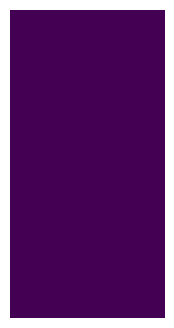

In [29]:
def get_x(i): return zscore_normalize(load_nifti(img_files[i]))
def get_y(i): return extract_target_mask(load_nifti(mask_files[i]), label_codes, targets)

class ToTensor3D(Transform):
    def encodes(self, x):
        t = torch.tensor(x, dtype=torch.float32)
        if t.ndim == 3:
            t = t.unsqueeze(0)  # (D, H, W) -> (1, D, H, W)
        elif t.ndim == 4 and t.shape[0] == 1:
            pass  # already (1, D, H, W)
        elif t.ndim == 4 and t.shape[-1] == 1:
            t = t.permute(3, 0, 1, 2)  # (D, H, W, 1) -> (1, D, H, W)
        else:
            raise ValueError(f"Unexpected image shape: {t.shape}")
        return t
    def decodes(self, x): return x.squeeze()

class ToTensorMask3D(Transform):
    def encodes(self, x): return torch.tensor(x, dtype=torch.long)
    def decodes(self, x): return x

dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=ToTensor3D()), TransformBlock(type_tfms=ToTensorMask3D())),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(seed=42),
)
dls = dblock.dataloaders(range(len(img_files)), bs=1)
dls.show_batch(max_n=1)


## Model Definitions (MONAI)
- 3D U-Net
- 3D ResNet


In [30]:
n_classes = len(targets) + 1  # background + targets

unet3d = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
   num_res_units=2,
    norm='batch'
    )

resnet3d = resnet.resnet10(spatial_dims=3, n_input_channels=1, num_classes=n_classes)


## fastai Learner Setup
- Use fastai's Learner for training


In [31]:
loss_func = nn.CrossEntropyLoss()
metrics = [DiceMulti(), JaccardCoeffMulti()]  # Use your custom metrics or fastai/monai

learn_unet = Learner(dls, unet3d, loss_func=loss_func, metrics=metrics)
learn_resnet = Learner(dls, resnet3d, loss_func=loss_func, metrics=metrics)


## Training
- Train both models


In [28]:
# Train U-Net
learn_unet.fine_tune(10)
# Train ResNet
learn_resnet.fine_tune(10)


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time


## Inference: Single and Batch
- Predict on a single image or a batch


In [ ]:
def predict_single(learn, img_path):
    img = zscore_normalize(load_nifti(img_path))
    img_t = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pred = learn.model(img_t.cuda()).argmax(1).cpu().numpy()[0]
    return pred

def predict_batch(learn, img_paths):
    preds = []
    for p in img_paths:
        preds.append(predict_single(learn, p))
    return preds


## Metrics & Evaluation
- Dice, Jaccard, etc.


In [ ]:
# Example: Evaluate on validation set
val_idxs = dls.valid.items
dice_scores = []
for i in val_idxs:
    img = get_x(i)
    mask = get_y(i)
    pred = predict_single(learn_unet, img_files[i])
    dice = (2 * (pred == mask).sum()) / ((pred > 0).sum() + (mask > 0).sum() + 1e-8)
    dice_scores.append(dice)
print(f'Mean Dice: {np.mean(dice_scores):.3f}')


## Visualization
- Show slices of input, ground truth, and prediction


In [ ]:
def show_slices(img, mask, pred, slice_idx=None):
    if slice_idx is None:
        slice_idx = img.shape[-1] // 2
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img[..., slice_idx], cmap='gray'); axs[0].set_title('Image')
    axs[1].imshow(mask[..., slice_idx]); axs[1].set_title('Mask')
    axs[2].imshow(pred[..., slice_idx]); axs[2].set_title('Prediction')
    plt.show()
